<a href="https://colab.research.google.com/github/AbderrhmanAbdellatif/CRM/blob/master/Customer%20Lifetime%20Value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Calculating Lifetime Value is the easy part. First we need to select a time window. It can be anything like 3, 6, 12, 24 months. By the equation below, we can have Lifetime Value for each customer in that specific time window:

### Lifetime Value: Total Gross Revenue - Total Cost

### This equation now gives us the historical lifetime value. If we see some customers having very high negative lifetime value historically, it could be too late to take an action. At this point, we need to predict the future with machine learning:

Let’s identify our path to glory:
1-Define an appropriate time frame for Customer Lifetime Value calculation  
2-Identify the features we are going to use to predict future and create them
3-Calculate lifetime value (LTV) for training the machine learning model
4-Build and run the machine learning model
5-Check if the model is useful

RFM scores for each customer ID  are the perfect candidates for feature set. To implement it correctly, we need to split our dataset. We will take 3 months of data, calculate RFM and use it for predicting next 6 months. So we need to create two dataframes first and append RFM scores to them.

In [0]:
#import libraries
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
#import machine learning related libraries
from sklearn.svm import SVC 
from sklearn.multioutput import MultiOutputClassifier 
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
import xgboost as xgb 
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import plotly.offline as pyoff
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import xgboost as xgb

#initate plotly
pyoff.init_notebook_mode()

In [0]:
#read data from csv and redo the data work we done before
tx_data = pd.read_csv('https://raw.githubusercontent.com/AbderrhmanAbdellatif/CRM/master/OnlineRetail.csv',encoding= 'unicode_escape')
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)
tx_uk.head()

# Create 3m and 6m dataframes

In [0]:

tx_3m = tx_uk[(tx_uk.InvoiceDate < datetime(2011,6,1)) & (tx_uk.InvoiceDate >= datetime(2011,3,1))].reset_index(drop=True)
tx_3m.head()

In [0]:
tx_6m = tx_uk[(tx_uk.InvoiceDate >= datetime(2011,6,1)) & (tx_uk.InvoiceDate < datetime(2011,12,1))].reset_index(drop=True)
tx_6m.head()

In [0]:
tx_user = pd.DataFrame(tx_3m['CustomerID'].unique())
tx_user.columns = ['CustomerID']
tx_user.head()

# Order cluster method

In [0]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

# calculate recency score

In [0]:
tx_max_purchase = tx_3m.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')

In [0]:
tx_user.head()

In [0]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [0]:
tx_user.head()

# calcuate frequency score

In [0]:
tx_frequency = tx_3m.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

In [0]:
tx_user.head()

In [0]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

In [0]:
tx_user.head()

## calcuate revenue score


In [0]:
tx_3m['Revenue'] = tx_3m['UnitPrice'] * tx_3m['Quantity']
tx_revenue = tx_3m.groupby('CustomerID').Revenue.sum().reset_index()
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

## overall scoring


In [0]:
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [0]:
tx_user.head(10)

## calculate revenue and create a new dataframe for it

In [0]:
tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']
tx_user_6m = tx_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
tx_user_6m.columns = ['CustomerID','m6_Revenue']

In [0]:
tx_user_6m.head()

In [0]:
#plot LTV histogram
plot_data = [
    go.Histogram(
        x=tx_user_6m.query('m6_Revenue < 10000')['m6_Revenue']
    )
]

plot_layout = go.Layout(
        title='6m Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

### Histogram clearly shows we have customers with negative LTV. We have some outliers too. Filtering out the outliers makes sense to have a proper machine learning model.

# We will merge our 3 months and 6 months dataframes to see correlations between LTV and the feature set we have.

In [0]:
tx_merge = pd.merge(tx_user, tx_user_6m, on='CustomerID', how='left')

In [0]:
tx_merge.head()

In [0]:
tx_graph = tx_merge.query("m6_Revenue < 30000")

In [0]:
tx_graph.head()

# The code below merges our feature set and LTV data and plots LTV vs overall RFM score:

In [0]:
plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Low-Value'")['m6_Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Mid-Value'")['m6_Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'High-Value'")['m6_Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "6m LTV"},
        xaxis= {'title': "RFM Score"},
        title='LTV'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Before building the machine learning model, we need to identify what is the type of this machine learning problem. LTV itself is a regression problem. A machine learning model can predict the $ value of the LTV. But here, we want LTV segments. Because it makes it more actionable and easy to communicate with other people. By applying K-means clustering, we can identify our existing LTV groups and build segments on top of it.
Considering business part of this analysis, we need to treat customers differently based on their predicted LTV. For this example, we will apply clustering and have 3 segments (number of segments really depends on your business dynamics and goals):
Low LTV
Mid LTV
High LTV
We are going to apply K-means clustering to decide segments and observe their characteristics:


In [0]:
#remove outliers
tx_merge = tx_merge[tx_merge['m6_Revenue']<tx_merge['m6_Revenue'].quantile(0.99)]

In [0]:
tx_merge.head()

In [0]:
#creating 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_merge[['m6_Revenue']])
tx_merge['LTVCluster'] = kmeans.predict(tx_merge[['m6_Revenue']])

In [0]:
tx_merge.head()

In [0]:
#order cluster number based on LTV
tx_merge = order_cluster('LTVCluster', 'm6_Revenue',tx_merge,True)
tx_merge.head()

In [0]:
#creatinga new cluster dataframe
tx_cluster = tx_merge.copy()

#see details of the clusters
tx_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

2 is the best with average 8.2k LTV whereas 0 is the worst with 396.

There are few more step before training the machine learning model:
- Need to do some feature engineering. We should convert categorical columns to numerical columns.
- We will check the correlation of features against our label, LTV clusters.
- We will split our feature set and label (LTV) as X and y. We use X to predict y.
- Will create Training and Test dataset. Training set will be used for building the machine learning model. We will apply our     model to Test set to see its real performance.

### We have finished LTV clustering and here are the characteristics of each clusters


2 is the best with average 8.2k LTV whereas 0 is the worst with 396.

There are few more step before training the machine learning model:

    Need to do some feature engineering. We should convert categorical columns to numerical columns.
    We will check the correlation of features against our label, LTV clusters.
    We will split our feature set and label (LTV) as X and y. We use X to predict y.
    Will create Training and Test dataset. Training set will be used for building the machine learning model. We will apply our model to Test set to see its real performance.
    

In [0]:
#convert categorical columns to numerical
tx_class = pd.get_dummies(tx_cluster)

In [0]:
tx_class.head()

###calculate and show correlations


In [0]:
corr_matrix = tx_class.corr()

In [0]:
corr_matrix

In [0]:
corr_matrix['LTVCluster'].sort_values(ascending=False)

In [0]:
corr_matrix

###create X and y, X will be feature set and y is the label - LTV

In [0]:
X = tx_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = tx_class['LTVCluster']

In [0]:
X.head()

In [0]:
y.head()

###split training and test sets


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

In [0]:
X_train.head()

In [0]:
X_test.head()

In [0]:
 y_train.head()

In [0]:
y_test.head()

Let’s start with the first line. get_dummies() method converts categorical columns to 0–1 notations. See what it exactly does with the example:

In [0]:
tx_cluster.head()

This was our dataset before get_dummies(). We have one categorical column which is Segment. What happens after applying get_dummies():

In [0]:
tx_class.head()

Segment column is gone but we have new numerical ones which represent it. We have converted it to 3 different columns with 0 and 1 and made it usable for our machine learning model.

#Gaussian Naive Bayes classifier

**Gaussian NB is based on the Naive Bayes theorem with the assumption of conditional independence between every pair of features given the label of the target class. The Graph for the likelihood of the feature vectors is Gaussian.**

![Gaussian Naive Bayes classifier](https://www.codespeedy.com/wp-content/uploads/2019/12/iris_gaussian.png)




In [0]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred_test = gnb.predict(X_test)
from sklearn.metrics import accuracy_score
NB = accuracy_score(y_test,y_pred_test)
NB

#Logistic Regression 

**Logistic Regression is one of the basic and powerful classifiers used in the machine learning model used for binary as well as multiclass classification problems. Let us apply logistic regression in the same way as we have applied the GaussianNB on the Iris dataset that we have and will be printing the accuracy score for this model as well.**


In [0]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver = 'lbfgs',multi_class='auto')
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score
LR = accuracy_score(y_test,y_pred)
LR

#Decision tree classifier 
**Decision Tree classifier is a widely used classification technique where several conditions are put on the dataset in a hierarchical manner until the data corresponding to the labels is purely separated. **



In [0]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred2 = dt.predict(X_test)
DT = accuracy_score(y_test,y_pred2)
DT

#KNN (k-nearest neighbors) classifier 

 KNN classifier is a very simple technique for classification and it is based upon the Euclidean distance between two data points calculated by taking the distance between the feature vector.
In case of the same distance between a data point and data points belonging to two or more different classes then, the next lowest distance is calculated and it is assumed that the data point will belong to that class. The formula to calculate Euclidean distance between two data points is:

![](https://www.codespeedy.com/wp-content/uploads/2019/12/iris_euclidean.png)

In [0]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3,algorithm='ball_tree')
clf.fit(X_train,y_train)
y_pred3 = clf.predict(X_test)
KNN =   accuracy_score(y_test,y_pred3)
KNN

#Support Vector Machine
Support Vector Machine or SVM is a classifier that classifies the data points into the classes(Supervised Learning) and separates those classes using a hyperplane.


In [0]:
from sklearn.svm import SVC
svc1 = SVC(C=50,kernel='rbf',gamma=1)     
svc1.fit(X_train,y_train)
y_pred4 = svc1.predict(X_test)
from sklearn.metrics import accuracy_score
SVM=accuracy_score(y_test,y_pred4)
SVM

# Random Forest Classifier 


In [0]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)
y_pred5 = classifier.predict(X_test)
from sklearn.metrics import accuracy_score
RF=accuracy_score(y_test,y_pred5)
RF

In [0]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTree', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(n_splits=2)
	cv_results = model_selection.cross_val_score(model,X_train, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [0]:
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))

In [0]:
models

In [0]:
for name,model in models:
    kfold = KFold(n_splits=2)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

#SVM Multiclassification Model

In [0]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn import svm, neighbors

clf = VotingClassifier([('lsvc', svm.LinearSVC()),
                            ('knn', neighbors.KNeighborsClassifier()),
                            ('rfor', RandomForestClassifier())])

clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print('accuracy:', confidence)

In [0]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(scaler.fit(X_train))
StandardScaler()
#print(scaler.mean_)
print(scaler.transform(X_train))

In [0]:
clf = LinearSVC(random_state=0, tol=1e-5,max_iter=1200000,dual=False)
svm_mul_class_model = clf.fit(X_train, y_train)
svm_mul_class_model


In [0]:
print('Accuracy of SVM classifier on training set: {:.2f}'
       .format(svm_mul_class_model.score(X_train, y_train)))

In [0]:
print('Accuracy of SVM classifier on test set: {:.2f}'
       .format(svm_mul_class_model.score(X_test[X_train.columns], y_test)))

In [0]:

# Transforming non numerical labels into numerical labels
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
# Dimension of Train and Test set 

# encoding train labels 
encoder.fit(y_train)
y_train = encoder.transform(y_train)

# encoding test labels 
encoder.fit(y_test)
y_test = encoder.transform(y_test)
names_of_predictors = list(X_train.columns.values)

# Scaling the Train and Test feature set 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#Hyperparameter tuning using grid search and cross validation


In [0]:
#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]                    

#Training SVM model using radial kernel

In [418]:
# Performing CV to tune parameters for best SVM fit 
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [419]:
print(svm_model)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)


#Confusion Matrix and Accuracy Score

In [420]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

Best score for training data: 0.8769237518645259 



In [421]:
# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

Best C: 10 

Best Kernel: rbf 

Best Gamma: 0.001 



In [0]:
final_model = svm_model.best_estimator_
Y_pred = final_model.predict(X_test_scaled)
Y_pred_label = list(encoder.inverse_transform(Y_pred))

In [423]:
# Making the Confusion Matrix
#print(pd.crosstab(Y_test_label, Y_pred_label, rownames=['Actual Activity'], colnames=['Predicted Activity']))
print(confusion_matrix(y_test,Y_pred_label))
print("\n")
print(classification_report(y_test,Y_pred_label))

print("Training set score for SVM: %f" % final_model.score(X_train_scaled , y_train))
print("Testing  set score for SVM: %f" % final_model.score(X_test_scaled  , y_test ))

svm_model.score

[[54  0  0]
 [10  2  1]
 [ 0  2  0]]


              precision    recall  f1-score   support

           0       0.84      1.00      0.92        54
           1       0.50      0.15      0.24        13
           2       0.00      0.00      0.00         2

    accuracy                           0.81        69
   macro avg       0.45      0.38      0.38        69
weighted avg       0.75      0.81      0.76        69

Training set score for SVM: 0.876147
Testing  set score for SVM: 0.811594


<bound method BaseSearchCV.score of GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)>

#XGBoost Multiclassification Model

In [0]:
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

In [425]:
ltv_xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [426]:
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))

Accuracy of XGB classifier on training set: 0.96


In [427]:
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on test set: 0.77


##We can identify that by looking at classification report:

In [428]:
y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89        54
           1       0.29      0.15      0.20        13
           2       0.00      0.00      0.00         2

    accuracy                           0.77        69
   macro avg       0.37      0.37      0.36        69
weighted avg       0.71      0.77      0.73        69



First we need to check our benchmark. Biggest cluster we have is cluster 0 which is 76.5% of the total base. If we blindly say, every customer belongs to cluster 0, then our accuracy would be 76.5%.

84% vs 76.5% tell us that our machine learning model is a useful one but needs some improvement for sure. We should find out where the model is failing.

Precision and recall are acceptable for 0. As an example, for cluster 0 (Low LTV), if model tells us this customer belongs to cluster 0, 90 out of 100 will be correct (precision). And the model successfully identifies 93% of actual cluster 0 customers (recall). We really need to improve the model for other clusters. For example, we barely detect 56% of Mid LTV customers. Possible actions to improve those points:

    Adding more features and improve feature engineering
    Try different models other than XGBoost
    Apply hyper parameter tuning to current model
    Add more data to the model if possible

#Performance Comparison
In the previous sections we have used the **accuracy_score()** method to measure the accuracy of the different algorithms. Now, we will use the `ClassificationReport` class provided by the **Yellowbrick** library to give us a visual report of how our models perform.

#GaussianNB

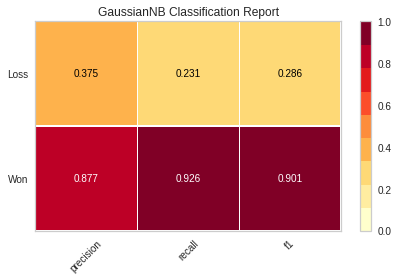

In [429]:
from yellowbrick.classifier import ClassificationReport
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(gnb, classes=['Won','Loss'])
visualizer.fit(X_train,y_train) # Fit the training data to the visualizer
visualizer.score(X_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

In the code above, first we import the ClassificationReport class provided by the yellowbrick.classifier module. Next, an object visualizer of the type ClassificationReport is created. Here the first argument is the GaussianNB object gnb that was created while implementing the Naive-Bayes algorithm in the ‘Naive-Bayes’ section. The second argument contains the labels ‘Won’ and ‘Loss’ from the ‘Opportunity Result’ column from the sales_data dataframe.

Next, we use the fit() method to train the visualizer object. This is followed by the score() method, which uses gnb object to carry out predictions as per the GaussianNB algorithm and then calculate the accuracy score of the predictions made by this algorithm. Finally, we use the poof() method to draw a plot of the different scores for the GaussianNB algorithm. Notice how the different scores are laid out against each of the labels ‘Won’ and ‘Loss’; this enables us to visualize the scores across the different target classes.



In [0]:
from yellowbrick.classifier import ClassificationReport
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(svm_model, classes=['Won','Loss'])
visualizer.fit(X_train,y_train) # Fit the training data to the visualizer
visualizer.score(X_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data